In [1]:
import torch
torch.__version__

'2.4.0+cu121'

In [2]:
# Import Colab Secrets userdata module
from google.colab import userdata

ModuleNotFoundError: No module named 'google.colab'

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-bkpuc32o
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-bkpuc32o
  Resolved https://github.com/huggingface/diffusers.git to commit 73acebb8cfbd1d2954cabe1af4185f9994e61917
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.2/417.2 kB 24.3 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2467704 sha256=3bf8e60fae3ef6d3e8f1efff29ee7214ce204ea2a0551c589d285abadc2cb604
  Stored in directory: /tmp/pip-ephem-wheel-cache-y9epz_8p/wheels/23/0f/7d/f97813d265ed0e599a78d83afd4e1925740896ca79b46cccfd
Successfully built diffusers
  Attempting uninstall: huggingface-hub
    Found existing install

In [4]:
    !pip install tensorboard tensorboardX

Defaulting to user installation because normal site-packages is not writeable


In [5]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

/home/ubuntu/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.22it/s]


'/home/ubuntu/dog'

In [6]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

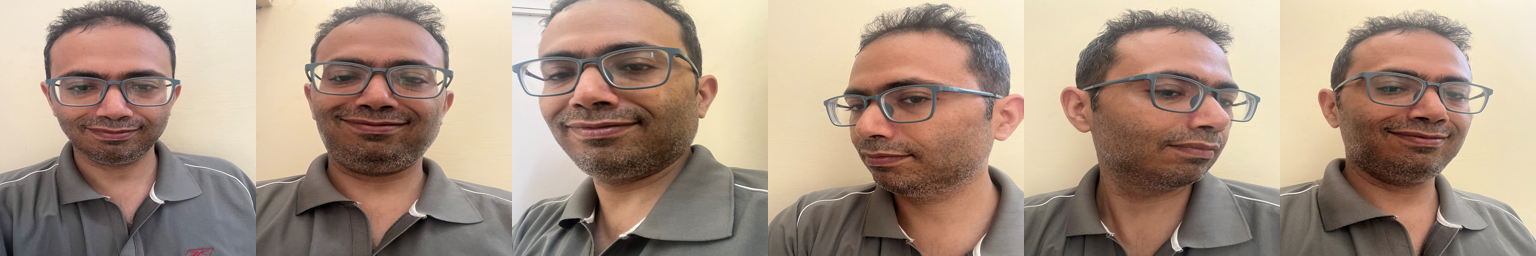

In [7]:
import glob

imgs = [Image.open(path) for path in glob.glob("./ansz/*.jpg")]
len(imgs)
image_grid(imgs, 1, 6)

In [11]:
MODEL_NAME="stabilityai/stable-diffusion-xl-base-1.0"
INSTANCE_DIR="ansz"
OUTPUT_DIR="lora-trained-xl"
VAE_PATH="madebyollin/sdxl-vae-fp16-fix"

In [9]:
!pip install accelerate

Defaulting to user installation because normal site-packages is not writeable


In [10]:
!pip install peft

Defaulting to user installation because normal site-packages is not writeable


In [12]:
! accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --pretrained_vae_model_name_or_path=$VAE_PATH \
  --output_dir=$OUTPUT_DIR \
  --mixed_precision="no" \
  --instance_prompt="a photo of sks man" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --report_to="tensorboard" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --checkpointing_steps=717

07/28/2024 07:59:28 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

/home/ubuntu/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
tokenizer/tokenizer_config.json: 100%|█████████| 737/737 [00:00<00:00, 7.99MB/s]
tokenizer/vocab.json: 100%|████████████████| 1.06M/1.06M [00:00<00:00, 17.5MB/s]
tokenizer/merges.txt: 100%|██████████████████| 525k/525k [00:00<00:00, 26.5MB/s]
text_encoder/config.json: 100%|████████████████| 565/565 [00:00<00:00, 7.64MB/s]
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
text_encoder_2/config.json: 100%|█████████████

In [14]:
from diffusers import DiffusionPipeline
import torch

In [15]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:48<00:00,  6.99s/it]


In [16]:
pipe.load_lora_weights("./lora-trained-xl")

In [17]:
image = pipe("A picture of a sks man with a cat", num_inference_steps=25).images[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.74it/s]


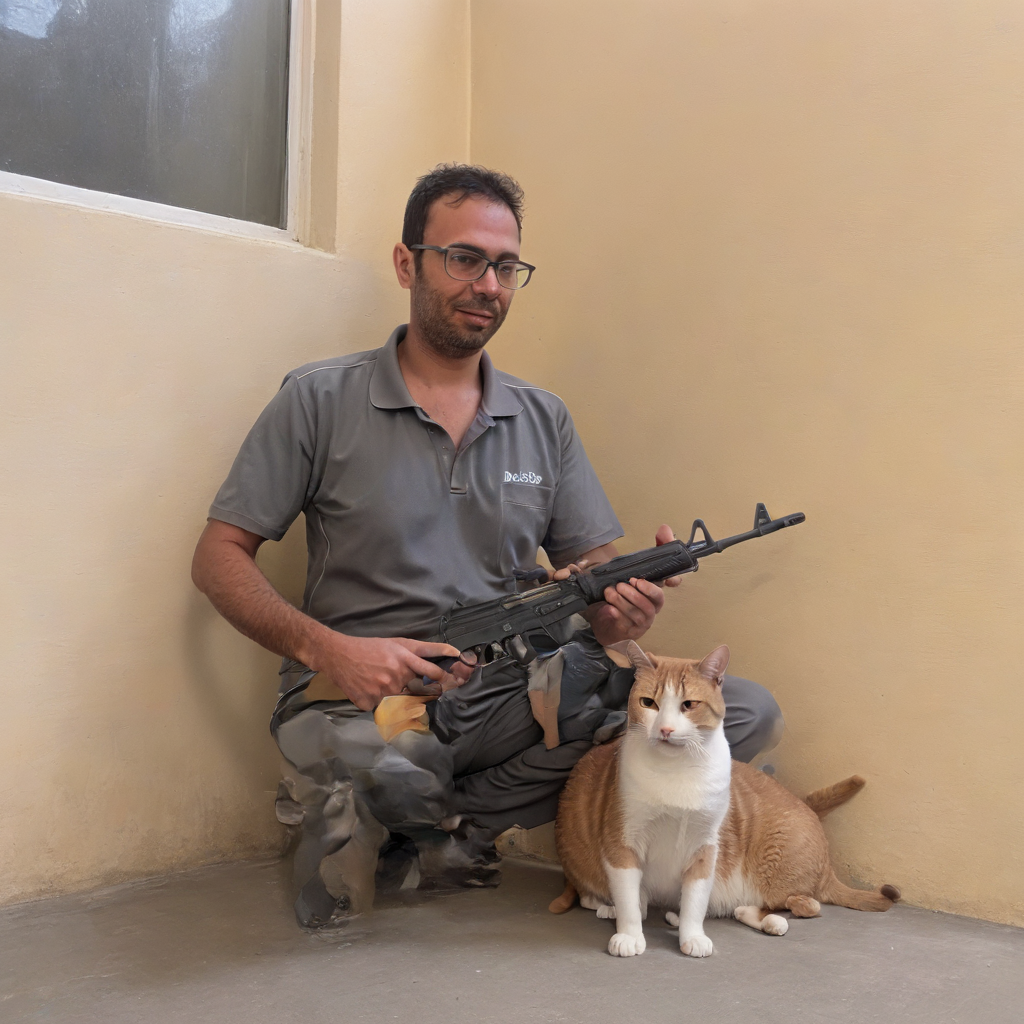

In [18]:
image

In [21]:
image = pipe("A picture of a sks man on everest", num_inference_steps=25).images[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.05it/s]


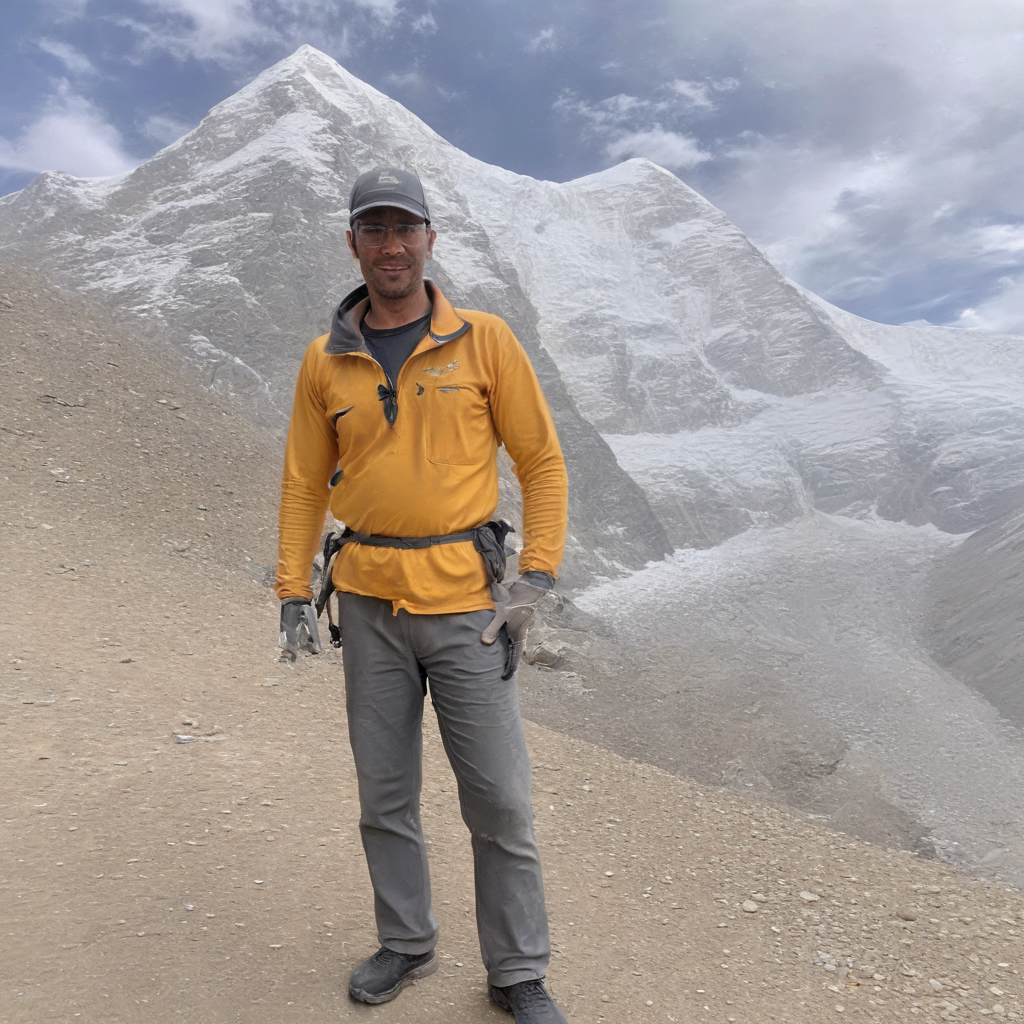

In [22]:
image